In [1]:
import numpy as np
import pandas as pd
import math

In [4]:
df = pd.read_csv('../data/skempi_v2.csv', sep=';')

In [7]:
df.isnull().sum()

#Pdb                               0
Mutation(s)_PDB                    0
Mutation(s)_cleaned                0
iMutation_Location(s)              0
Hold_out_type                   3682
Hold_out_proteins                  0
Affinity_mut (M)                   0
Affinity_mut_parsed              285
Affinity_wt (M)                    0
Affinity_wt_parsed                 2
Reference                          0
Protein 1                          0
Protein 2                          0
Temperature                        4
kon_mut (M^(-1)s^(-1))          5169
kon_mut_parsed                  5169
kon_wt (M^(-1)s^(-1))           5160
kon_wt_parsed                   5160
koff_mut (s^(-1))               5169
koff_mut_parsed                 5169
koff_wt (s^(-1))                5153
koff_wt_parsed                  5153
dH_mut (kcal mol^(-1))          6550
dH_wt (kcal mol^(-1))           6550
dS_mut (cal mol^(-1) K^(-1))    6550
dS_wt (cal mol^(-1) K^(-1))     6550
Notes                           4023
M

In [9]:
n = df[df.isnull()]

In [24]:
math.isnan(n["Temperature"][0])

True

In [33]:
df = pd.DataFrame(columns=['A', 'B', 'C', 'D', 'E_e', 'F'])

for i in range(5):
    df = df.append({'A': i, 'B': i*i,'C': i*i,'D': i*i,'E_e': i*i,'F': i*i*0.1}, ignore_index=True)

In [34]:
df

,A,B,C,D,E_e,F
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.1
2,2.0,4.0,4.0,4.0,4.0,0.4
3,3.0,9.0,9.0,9.0,9.0,0.9
4,4.0,16.0,16.0,16.0,16.0,1.6


In [3]:
a=np.random.rand(10)
print(a)
ids=np.argsort(a)
print(a)

[0.08908054 0.37069276 0.79988754 0.24899294 0.46591939 0.89694443
 0.29566966 0.8351025  0.83748567 0.52218045]
[0.08908054 0.37069276 0.79988754 0.24899294 0.46591939 0.89694443
 0.29566966 0.8351025  0.83748567 0.52218045]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
# generate train and test  split. We will use k-fold on the train data for tuning our model
for hyperparam in hyperparams:
           for k_indices in k_fold_indices:
                       train = train[~k_indices]
                       test = test[k_indices] # these two lines are applied for input and output data
                       train_model(train, test)
                       obtain metric for model
             average out model metrics for all k folds for this hyperparam config and store the info

In [19]:
import numpy as np
from pathlib import Path
import parmed as pmd
import simtk.unit as su
import simtk.openmm as so
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

In [8]:
a=np.floor(np.random.rand(5,10)*100)
print(a)

[[74. 86. 11. 77. 20. 71. 41.  2. 21. 68.]
 [48. 67. 30. 57. 51. 43. 43. 52. 23. 55.]
 [47. 45. 64. 47. 32. 61. 78. 10. 68. 15.]
 [58. 49. 84.  1.  1. 78. 59. 41. 60. 66.]
 [54. 38. 53. 82. 96. 69. 43. 69. 25. 48.]]


In [16]:
idx = np.argmin(a)
row, col = int(idx/a.shape[1]), idx%a.shape[1]

## example PDB info

In [20]:
pdb_path='../data/pdbs_wt/'
fname='1A22_A_B.pdb'

clean PDB

In [21]:
pdb = pmd.load_file(pdb_path + fname)
pdb.save('/tmp/' + fname, overwrite=True)

fixer = PDBFixer(filename='/tmp/' + fname)
Path('/tmp/' + fname).unlink()
fixer.findMissingResidues()
fixer.findNonstandardResidues()
# print(f'number of non-standard residues in {fname}: {len(fixer.nonstandardResidues)}')
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)

init simulation system

In [23]:
forcefield = so.app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
system = forcefield.createSystem(fixer.topology, nonbondedMethod=so.app.NoCutoff)
param = pmd.openmm.load_topology(fixer.topology, system=system, xyz=fixer.positions)

get chain information

In [28]:
# get indices of atoms for the 2 interacting subunits
base_fname = fname.split('.')[0]
sub_unit_chains = [[char for char in subchain] for subchain  in base_fname.split('_')[1:3]]
print(f'chains: {sub_unit_chains}')
ids0, ids1 = (np.where(param.to_dataframe()['chain'].isin(cids))[0] for cids in sub_unit_chains)

chains: [['A'], ['B']]


#### run simulation

In [29]:
# constants
eps0 = 8.8541878128e-12 * su.farad * su.meter**-1
e = 1.60217662e-19 * su.coulomb
N = 6.02214179e23 * su.mole**-1 # Avogadro

# scaling factors
k0 = (N * (e*e) / (4.0 * np.pi * eps0))

# get nonbonded interactions parameters for all atoms (Lennard-Jones and electrostatics)
epsilon = np.array([a.epsilon for a in param.atoms])
sigma = np.array([a.sigma for a in param.atoms])
charge = np.array([a.charge for a in param.atoms])

# pairwise epsilon with units
E = np.sqrt(epsilon[ids0].reshape(-1,1) * epsilon[ids1].reshape(1,-1)) * param.atoms[0].uepsilon.unit

# pairwise sigma with units
S = 0.5*(sigma[ids0].reshape(-1,1) + sigma[ids1].reshape(1,-1)) * param.atoms[0].usigma.unit

# pairwise partial charges
Q = charge[ids0].reshape(-1,1) * charge[ids1].reshape(1,-1)

# setup MD engine
integrator = so.LangevinIntegrator(300*su.kelvin, 1/su.picosecond, 0.002*su.picoseconds)
platform = so.Platform.getPlatformByName('CUDA')
simulation = so.app.Simulation(param.topology, system, integrator, platform)

# set atom coordinates
simulation.context.setPositions(param.get_coordinates()[0] * su.angstrom)

# minimize energy
simulation.minimizeEnergy()


get atom coordinates and compute distance matrix between subunits

In [30]:
state = simulation.context.getState(getPositions=True)
xyz = state.getPositions(asNumpy=True)
D = np.linalg.norm(np.expand_dims(xyz[ids0], 1) - np.expand_dims(xyz[ids1], 0), axis=2) * su.angstrom

visualize distance matrix. The rows correspond to the atoms in protein 1, while the collumns correspond to the atoms in protein 2

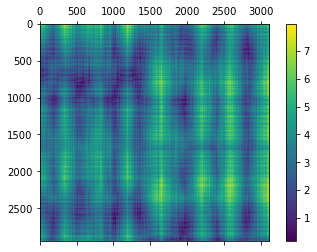

In [38]:
import matplotlib.pyplot as plt
figure = plt.figure() 
axes = figure.add_subplot(111) 

caxes = axes.matshow(D) 
figure.colorbar(caxes) 
  
plt.show() 

choose the proper submatrix for the features

In [58]:
D.shape

(2949, 3108)

In [60]:
n_interactions = 128

min_i = np.argmin(D)
min_r, min_c = int(min_i/D.shape[1]), min_i%D.shape[1]
print(np.min(D), (min_r, min_c))

ids0_min, ids0_max = min_r-n_interactions/2, min_r+n_interactions/2
ids1_min, ids1_max = min_c-n_interactions/2, min_c+n_interactions/2

if ids0_min < 0:
    ids0_max -= ids0_min
    ids0_min = 0
elif ids0_max >= D.shape[0]:
    ids0_min -= ids0_max - D.shape[0] + 1
    ids0_max = D.shape[0]-1
    
if ids1_min < 0:
    ids1_max -= ids1_min
    ids1_min = 0
elif ids1_max >= D.shape[1]:
    ids1_min -= ids1_max - D.shape[1] + 1
    ids1_max = D.shape[1]-1

ids0_interacting = np.arange(ids0_min, ids0_max, dtype=np.int32)
ids1_interacting = np.arange(ids1_min, ids1_max, dtype=np.int32)

0.1580238445935004 A (2933, 2404)


plot submatrix

In [61]:
sub_D = D[np.ix_(ids0_interacting, ids1_interacting)]

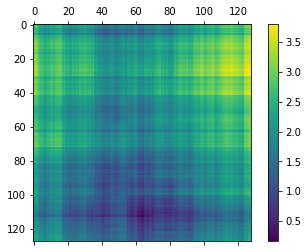

In [62]:
figure = plt.figure() 
axes = figure.add_subplot(111) 

caxes = axes.matshow(sub_D) 
figure.colorbar(caxes) 
  
plt.show() 